In [1]:
import warnings
warnings.filterwarnings('ignore')

In [57]:
import os
import time
import re
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import random
import sklearn

from tensorflow.keras.preprocessing.image import img_to_array
from glob import glob
from sklearn.metrics import roc_auc_score, roc_curve, auc, precision_recall_curve, average_precision_score, confusion_matrix
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, CSVLogger
from tensorflow.keras.utils import plot_model
from keras.preprocessing import image
from keras import backend as K
from tensorflow.keras.metrics import AUC, Precision, Recall
from keras.preprocessing.image import ImageDataGenerator
from mlxtend.plotting import plot_confusion_matrix

tf.compat.v1.disable_eager_execution()
from tensorflow.compat.v1.logging import INFO, set_verbosity

random.seed(a=None, version=2)

set_verbosity(INFO)
%matplotlib inline

In [3]:
IMAGE_SIZE = (320, 320)
BATCH_SIZE = 8
EPOCHS = 30
VALIDATION_PCT = 0.20

In [4]:
# Define Path to the Chest-Xray Data Directory
DATA_DIR = 'G:/Downloads/archive/chest_xray'

# Training Data Directory
TRAIN_DIR = os.path.join(DATA_DIR,'train')

# Validation Data Directory
VALID_DIR = os.path.join(DATA_DIR,'val')

# Test Data Directory
TEST_DIR = os.path.join(DATA_DIR,'test')

In [5]:
def get_file_count(DIR, LABEL):
    return len([filename for filename in glob(os.path.join(DIR, '*', '*.jpeg')) if LABEL in filename])

In [6]:
CLASS_NAMES = np.array([class_name.split(os.path.sep)[-1] for class_name in glob(os.path.join(TRAIN_DIR,"*"))])
CLASS_NAMES

array(['NORMAL', 'PNEUMONIA'], dtype='<U9')

In [7]:
train_pre_normal = get_file_count(TRAIN_DIR, "NORMAL")
valid_pre_normal = get_file_count(VALID_DIR, "NORMAL")
train_pre_pneumonia = get_file_count(TRAIN_DIR, "PNEUMONIA")
valid_pre_pneumonia = get_file_count(VALID_DIR, "PNEUMONIA")

print(f"Pneumonia cases in Training Set: {train_pre_pneumonia}")
print(f"Normal cases in Training Set: {train_pre_normal}")
print()
print(f"Pneumonia cases in Validation Set: {valid_pre_pneumonia}")
print(f"Normal cases in Validation Set: {valid_pre_normal}")

Pneumonia cases in Training Set: 3875
Normal cases in Training Set: 1341

Pneumonia cases in Validation Set: 8
Normal cases in Validation Set: 8


In [8]:
def get_label(file_path):
    return 1 if file_path.split(os.path.sep)[-2] == "PNEUMONIA" else 0

In [9]:
filenames = glob(os.path.join(TRAIN_DIR, "*", "*.*"))
filenames.extend(glob(os.path.join(VALID_DIR, "*", "*.*")))

In [10]:
all_data = []
for path in filenames:
    label = get_label(path)
    all_data.append((path, label))

all_data = pd.DataFrame(all_data, columns=['Path','Pneumonia'], index=None)    
all_data = all_data.sample(frac=1.).reset_index(drop=True)

In [11]:
train_set, val_set = train_test_split(all_data, test_size=0.20, stratify=all_data['Pneumonia'])

In [12]:
train_post_count = train_set['Pneumonia'].value_counts()
print(train_post_count)

1    3106
0    1079
Name: Pneumonia, dtype: int64


In [13]:
val_post_count = val_set['Pneumonia'].value_counts()
print(val_post_count)

1    777
0    270
Name: Pneumonia, dtype: int64


In [14]:
print(f'Total Pneumonia Cases: {all_data[all_data.Pneumonia==1].shape[0]}')
print(f'{(1-VALIDATION_PCT)*100}% Pneumonia Cases: {int(all_data[all_data.Pneumonia==1].shape[0]*(1-VALIDATION_PCT))}')
print(f'{VALIDATION_PCT*100}% Pneumonia Cases: {int(all_data[all_data.Pneumonia==1].shape[0]*VALIDATION_PCT)}')
print()
print(f'Pneumonia Cases in Training set: {train_set[train_set.Pneumonia==1].shape[0]}')
print(f'Pneumonia Cases in Validation set: {val_set[val_set.Pneumonia==1].shape[0]}')
print()
print(f'Train Set Size: {train_set.shape[0]}')
print(f'Pos %: {train_set[train_set.Pneumonia==1].shape[0] / train_set.shape[0] *100}')
print(f'Neg %: {train_set[train_set.Pneumonia==0].shape[0] / train_set.shape[0] *100}')
print()
print(f'Validation Set Size: {val_set.shape[0]}')
print(f'Pos %: {val_set[val_set.Pneumonia == 1].shape[0] / val_set.shape[0] *100}')
print(f'Neg % {val_set[val_set.Pneumonia == 0].shape[0] / val_set.shape[0] *100}')

Total Pneumonia Cases: 3883
80.0% Pneumonia Cases: 3106
20.0% Pneumonia Cases: 776

Pneumonia Cases in Training set: 3106
Pneumonia Cases in Validation set: 777

Train Set Size: 4185
Pos %: 74.2174432497013
Neg %: 25.782556750298685

Validation Set Size: 1047
Pos %: 74.21203438395415
Neg % 25.787965616045845


In [15]:
test_files = glob(os.path.join(TEST_DIR,'*','*.*'))

In [16]:
test_set = []
for path in test_files:
    label = get_label(path)
    test_set.append((path, label))
    
test_set = pd.DataFrame(test_set, columns=['Path', 'Pneumonia'], index=None)
test_set = test_set.sample(frac=1.).reset_index(drop=True)

In [17]:
def get_train_generator(df, x_col, y_col, shuffle=True, batch_size=BATCH_SIZE, seed=1, target_w = 320, target_h = 320):
    """
    Return generator for training set, normalizing using batch
    statistics.

    Args:
      train_df (dataframe): dataframe specifying training data.
      x_col (str): name of column in df that holds filenames.
      y_col (list): name of column in df as target
      sample_size (int): size of sample to use for normalization statistics.
      batch_size (int): images per batch to be fed into model during training.
      seed (int): random seed.
      target_w (int): final width of input images.
      target_h (int): final height of input images.
    
    Returns:
        train_generator (DataFrameIterator): iterator over training set
    """        
    print("[INFO] Getting Train Generator...") 
    # Normalize images
    image_generator = ImageDataGenerator(rescale=1.0/255.0,
        horizontal_flip=True,
        vertical_flip=False,
        rotation_range = 10,
        shear_range = 0.1,
        zoom_range = 0.15)
    
    # Flow from directory with specified batch size
    # and target image size
    generator = image_generator.flow_from_dataframe(
            dataframe=df,
            directory=None,
            x_col=x_col,
            y_col=y_col,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=shuffle,
            seed=seed,
            target_size=(target_w,target_h))
    return generator

In [18]:
def get_test_and_valid_generator(valid_df, test_df, train_df, x_col, y_col, sample_size=100, batch_size=BATCH_SIZE, seed=1, target_w = 320, target_h = 320):
    """
    Return generator for validation set and test test set using 
    normalization statistics from training set.

    Args:
      valid_df (dataframe): dataframe specifying validation data.
      test_df (dataframe): dataframe specifying test data.
      train_df (dataframe): dataframe specifying training data.
      x_col (str): name of column in df that holds filenames.
      y_col (list): name of column in df as target.
      sample_size (int): size of sample to use for normalization statistics.
      batch_size (int): images per batch to be fed into model during training.
      seed (int): random seed.
      target_w (int): final width of input images.
      target_h (int): final height of input images.
    
    Returns:
        test_generator (DataFrameIterator) and valid_generator: iterators over test set and validation set respectively
    """
    print("[INFO] Getting Valid and Test Generators...")
    # Get generator to sample dataset
    raw_train_generator = ImageDataGenerator().flow_from_dataframe(
        dataframe=train_df, 
        directory=None, 
        x_col=x_col, 
        y_col=y_col, 
        class_mode="raw", 
        batch_size=sample_size, 
        shuffle=True, 
        target_size=(target_w, target_h))
    
    # Get data sample
    batch = raw_train_generator.next()
    data_sample = batch[0]

    # Use sample to fit mean and std for test set generator
    image_generator = ImageDataGenerator(rescale=1.0/255.0)
    
    # Fit generator to sample from training data
    image_generator.fit(data_sample)

    # get test generator
    valid_generator = image_generator.flow_from_dataframe(
            dataframe=valid_df,
            directory=None,
            x_col=x_col,
            y_col=y_col,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))
    test_generator = image_generator.flow_from_dataframe(
            dataframe=test_df,
            directory=None,
            x_col=x_col,
            y_col=y_col,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))
    return valid_generator, test_generator

In [19]:
train_generator = get_train_generator(train_set, "Path", "Pneumonia")

[INFO] Getting Train Generator...
Found 4185 validated image filenames.


In [20]:
valid_generator, test_generator = get_test_and_valid_generator(val_set, test_set, train_set, "Path", "Pneumonia")

[INFO] Getting Valid and Test Generators...
Found 4185 validated image filenames.
Found 1047 validated image filenames.
Found 624 validated image filenames.


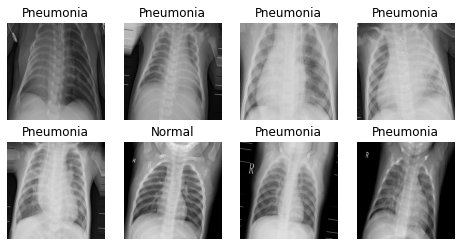

In [21]:
t_x, t_y = next(train_generator)
fig, m_axs = plt.subplots(2, 4, figsize = (8, 4))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'gray')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('Normal')
    c_ax.axis('off')

In [22]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()])
    return block

In [23]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    return block

In [24]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [25]:
# Correct for Data Imbalance
initial_bias = np.log(train_post_count[1]/train_post_count[0])
initial_bias

1.0573010384504977

In [26]:
def compute_class_freqs(labels):
    """
    Compute positive and negative frequences for each class.

    Args:
        labels (np.array): matrix of labels, size (num_examples, num_classes)
    Returns:
        positive_frequencies (np.array): array of positive frequences for each
                                         class, size (num_classes)
        negative_frequencies (np.array): array of negative frequences for each
                                         class, size (num_classes)
    """
    # Total number of patients (rows)
    N = labels.shape[0]
    
    positive_frequencies = np.sum(labels, axis=0) / N
    negative_frequencies = 1 - positive_frequencies
    
    return positive_frequencies, negative_frequencies

In [27]:
freq_pos, freq_neg = compute_class_freqs(train_generator.labels)

In [28]:
pos_weights = freq_neg
neg_weights = freq_pos

class_weights = {0: neg_weights, 1:pos_weights}

In [29]:
print("[INFO] Compiling Model...")
model = build_model()
METRICS = ['accuracy', AUC(), Precision(), Recall()]
model.compile(optimizer='adam', loss='binary_crossentropy',metrics=METRICS)
print("[INFO] Model Compiled...")

[INFO] Compiling Model...
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
[INFO] Model Compiled...


In [30]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 320, 320, 16)      448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 320, 320, 16)      2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 160, 160, 16)      0         
_________________________________________________________________
sequential (Sequential)      (None, 80, 80, 32)        2160      
_________________________________________________________________
sequential_1 (Sequential)    (None, 40, 40, 64)        7392      
_________________________________________________________________
sequential_2 (Sequential)    (None, 20, 20, 128)       27072     
_________________________________________________________________
dropout (Dropout)            (None, 20, 20, 128)      

In [31]:
x_ray_class = "Pneumonia_Detection_Model_Custom"
iteration = 1
_time = time.localtime()
prefix = time.strftime("%m_%d_%Y_%H_%M")

weight_path = f"Model_Checkpoints/{x_ray_class}_{prefix}_model_best.hdf5"

cb_checkpoint = ModelCheckpoint(weight_path,
                            monitor = 'val_loss',
                            verbose=1,
                            save_best_only=True,
                            mode='min',
                            save_weights_only=True)

cb_early = EarlyStopping(monitor='val_loss',
                     mode='min',
                     patience=10)
cb_csv_logger = CSVLogger(f'Logs/{x_ray_class}_{prefix}_log.csv', append=True, separator=';')

In [32]:
LRSchedular = False
if LRSchedular:
    def exponential_decay(lr0, s):
        def exponential_decay_fn(epoch):
            return lr0 * 0.1 **(epoch / s)
        return exponential_decay_fn

    exponential_decay_fn = exponential_decay(0.01, 20)

    lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

    call_backs_list = [cb_checkpoint, cb_early, lr_scheduler]
else:
    call_backs_list = [cb_checkpoint, cb_early, cb_csv_logger]

In [33]:
run_custom_training = True
if run_custom_training:
    t_start = time.time()
    print(f"[INFO] Model Training Started : {time.ctime(t_start)}")    
    history = model.fit(train_generator,
                        steps_per_epoch=len(train_set)//BATCH_SIZE,
                        epochs=EPOCHS,
                        validation_data=valid_generator,
                        validation_steps=len(val_set)//BATCH_SIZE,
                        class_weight=class_weights,
                        callbacks = call_backs_list)
    model.load_weights(weight_path)
    print(f"[INFO] Model Training Finished : {time.ctime(time.time())}")
    model.save("Models/Pneumonia_Detection_Model_Custom.h5")
    print(f"[INFO] Model Saved")
    t_finish = time.time()
    print(f'Training took {(t_finish - t_start) // 60} minutes')

[INFO] Model Training Started : Mon Oct  5 10:06:55 2020
Epoch 1/30
523/523 [==============================] - ETA: 0s - loss: 0.2080 - accuracy: 0.7314 - auc: 0.8243 - precision: 0.9008 - recall: 0.7172
Epoch 00001: val_loss improved from inf to 0.74632, saving model to Model_Checkpoints/Pneumonia_Detection_Model_Custom_10_05_2020_10_06_model_best.hdf5
523/523 [==============================] - 509s 973ms/step - loss: 0.2080 - accuracy: 0.7314 - auc: 0.8243 - precision: 0.9008 - recall: 0.7172 - val_loss: 0.7463 - val_accuracy: 0.7413 - val_auc: 0.4959 - val_precision: 0.7413 - val_recall: 1.0000
Epoch 2/30
523/523 [==============================] - ETA: 0s - loss: 0.1673 - accuracy: 0.8058 - auc: 0.8848 - precision: 0.9221 - recall: 0.8063
Epoch 00002: val_loss improved from 0.74632 to 0.69370, saving model to Model_Checkpoints/Pneumonia_Detection_Model_Custom_10_05_2020_10_06_model_best.hdf5
523/523 [==============================] - 507s 970ms/step - loss: 0.1673 - accuracy: 0.8058

Epoch 18/30
523/523 [==============================] - ETA: 0s - loss: 0.0998 - accuracy: 0.8937 - auc: 0.9577 - precision: 0.9699 - recall: 0.8840
Epoch 00018: val_loss did not improve from 0.14665
523/523 [==============================] - 546s 1s/step - loss: 0.0998 - accuracy: 0.8937 - auc: 0.9577 - precision: 0.9699 - recall: 0.8840 - val_loss: 0.2985 - val_accuracy: 0.8923 - val_auc: 0.9797 - val_precision: 0.9896 - val_recall: 0.8638
Epoch 19/30
523/523 [==============================] - ETA: 0s - loss: 0.0960 - accuracy: 0.8904 - auc: 0.9601 - precision: 0.9679 - recall: 0.8819
Epoch 00019: val_loss did not improve from 0.14665
523/523 [==============================] - 532s 1s/step - loss: 0.0960 - accuracy: 0.8904 - auc: 0.9601 - precision: 0.9679 - recall: 0.8819 - val_loss: 0.1716 - val_accuracy: 0.9356 - val_auc: 0.9826 - val_precision: 0.9796 - val_recall: 0.9326
Epoch 20/30
523/523 [==============================] - ETA: 0s - loss: 0.1037 - accuracy: 0.8851 - auc: 0.9568

In [34]:
# Functions for getting model predictions and plotting results       -------------#
def get_model_predictions(model_filepath, data):
    """
    Takes in a filepath to the saved model, loads in the model, and gets predictions for all data sent in.
    :param model_filepath: filepath to a saved model, must have .h5 extension
    :param data: Data to make predictions on
    :return: True labels, predictions
    """
    model = tf.keras.models.load_model(model_filepath)
    pred_y = model.predict(data)
    return [data for answer in pred_y for data in answer]

In [35]:
image_batch, true_y = next(iter(test_generator))

In [37]:
model_path = 'Models/Pneumonia_Detection_Model_Custom.h5'

In [38]:
pred_y = get_model_predictions(model_path, image_batch)

In [39]:
threshold = 0.135
pred_y_binary = [1.0 if pred > threshold else 0.0 for pred in pred_y]
pred_y_binary

[1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0]

In [40]:
# Create a confusion matrix and report performance statistics
matrix = confusion_matrix(true_y, pred_y_binary, labels=[1.0,0.0])
print(matrix)
TP, FN, FP, TN = matrix.flatten()
print(f'Recall: {TP/(TP+FN)*100:.2f}%')
print(f'Precision: {TP/(TP+FP)*100:.2f}%')
print(f'False Positive Rate: {FP/(FP+TN)*100:.2f}%')

[[4 0]
 [3 1]]
Recall: 100.00%
Precision: 57.14%
False Positive Rate: 75.00%


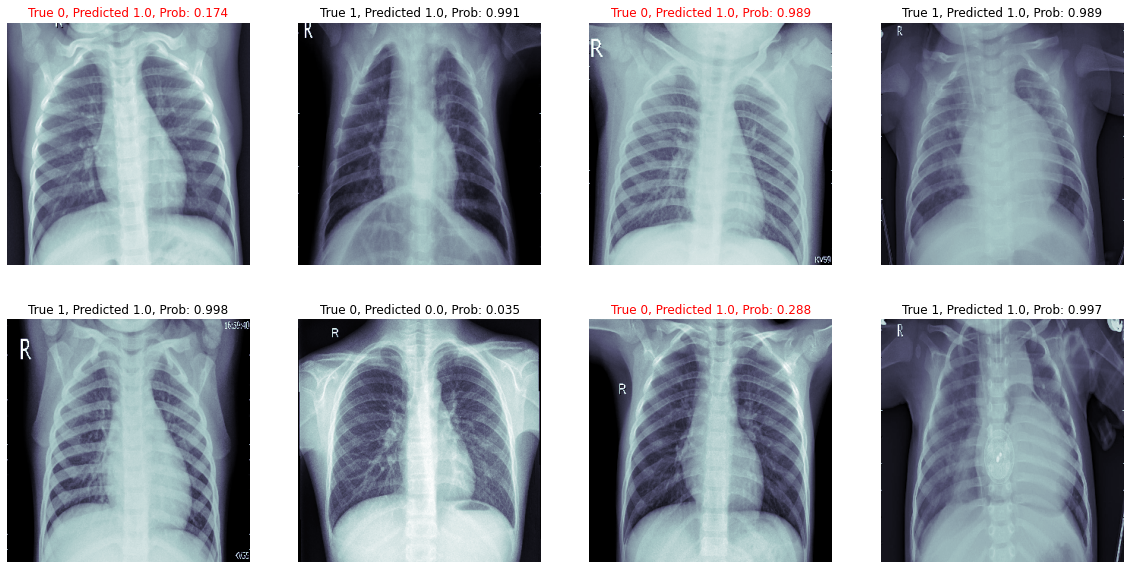

In [41]:
## Look at a sample of predicted v. true values along with model probabilities:
fig, m_axs = plt.subplots(2, 4, figsize = (20, 10))
i = 0
for (c_x, c_y, c_ax) in zip(image_batch[0:8], true_y[0:8], m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    prob = round(float(pred_y[i]),3)
    if c_y != pred_y_binary[i]:
        c_ax.set_title(f'True {c_y}, Predicted {pred_y_binary[i]}, Prob: {prob}', color = 'red')
    else:
        c_ax.set_title(f'True {c_y}, Predicted {pred_y_binary[i]}, Prob: {prob}', color = 'black')
    c_ax.axis('off')
    i=i+1

<Figure size 432x288 with 0 Axes>

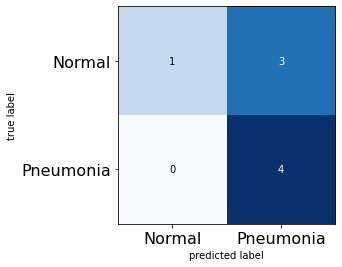

In [44]:
# Get the Confusion Matrix
cm = confusion_matrix(true_y, pred_y_binary)
plt.figure()
plot_confusion_matrix(cm, figsize=(4,4), hide_ticks=True, cmap=plt.cm.Blues)
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.savefig(f'Images/CM_Subset_Custom.png')
plt.show();

In [45]:
predicted_vals = model.predict(test_generator, steps = len(test_generator))

In [46]:
true_y = test_set['Pneumonia'].values

<Figure size 432x288 with 0 Axes>

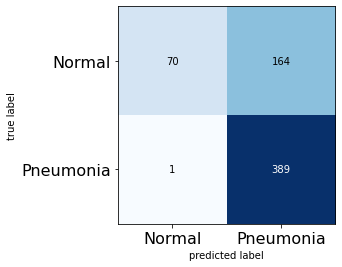

In [47]:
threshold = 0.135
pred_y_binary = [1.0 if pred > threshold else 0.0 for pred in predicted_vals]
pred_y_binary
cm = confusion_matrix(true_y, pred_y_binary)
plt.figure()
plot_confusion_matrix(cm, figsize=(4,4), hide_ticks=True, cmap=plt.cm.Blues)
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.savefig(f'Images/CM_Custom_Full_Test_Data.png')
plt.show();

In [48]:
model_evaluation = model.evaluate(test_generator)
print(f"Loss of Model on Test Set: {model_evaluation[0]*100:.2f}%")
print(f"Accuracy of Model on Test Set: {model_evaluation[1]*100:.2f}%")
print(f"AUC of Model on Test Set: {model_evaluation[2]*100:.2f}%")
print(f"Precision of Model on Test Set: {model_evaluation[3]*100:.2f}%")
print(f"Recall of Model on Test Set: {model_evaluation[4]*100:.2f}%")

Loss of Model on Test Set: 38.86%
Accuracy of Model on Test Set: 87.18%
AUC of Model on Test Set: 94.07%
Precision of Model on Test Set: 83.41%
Recall of Model on Test Set: 99.23%


In [50]:
history_logs = pd.read_csv('Logs/Pneumonia_Detection_Model_Custom_10_05_2020_10_06_log.csv',sep=';')
history_logs

,epoch,accuracy,auc,loss,precision,recall,val_accuracy,val_auc,val_loss,val_precision,val_recall
0,0,0.731386,0.824267,0.208130,0.900770,0.717188,0.741346,0.495919,0.746318,0.741346,1.000000
1,1,0.805841,0.884812,0.167398,0.922083,0.806264,0.840385,0.866817,0.693704,0.838746,0.971466
2,2,0.803687,0.877582,0.169702,0.921598,0.803871,0.788462,0.876398,0.445242,0.791534,0.970169
3,3,0.843428,0.921889,0.136592,0.949028,0.834032,0.741346,0.470817,1.805735,0.741346,1.000000
4,4,0.870242,0.941373,0.118199,0.958752,0.862258,0.924038,0.952951,0.219573,0.925061,0.976654
5,5,0.864257,0.938014,0.120906,0.953438,0.858987,0.827885,0.883710,0.375567,0.825991,0.972763
6,6,0.866172,0.935733,0.122129,0.960564,0.855072,0.918269,0.975456,0.204838,0.969863,0.918288
7,7,0.881255,0.946975,0.111021,0.960694,0.875726,0.842308,0.985525,0.340676,0.996727,0.789883
8,8,0.876945,0.944280,0.114154,0.961099,0.869270,0.745192,0.867895,0.691446,0.744209,1.000000
9,9,0.882452,0.947035,0.110795,0.963410,0.874839,0.914423,0.984168,0.201541,0.988539,0.894942


In [ ]:
def plot_roc_curve(model_name, true_y, pred_y):
    """
    Plot the ROC curve along with the curves AUC for a given model. Note make sure true_y and pred_y are from the same model as model_name
    :param model_name: Name of model used for saving plot
    :param true_y: true labels for dataset
    :param pred_y: predicted labels for dataset
    """
    fig, ax = plt.subplots(1,1, figsize=(7,7))
    fpr, tpr, thresholds = roc_curve(true_y, pred_y)
    ax.plot(fpr, tpr, label=f'{model_name} AUC: {auc(fpr,tpr)}')
    ax.legend()
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    plt.savefig(f'Images/{model_name}_roc.png')
    return

In [51]:
# Plot Model History
def plot_history(model_history, model_name):
    N = len(model_history['loss'])
    plt.style.use('ggplot')
    plt.figure()
    plt.plot(np.arange(0,N), model_history['loss'], label='train loss')
    plt.plot(np.arange(0,N), model_history['val_loss'], label='valuation loss')
    plt.plot(np.arange(0,N), model_history['accuracy'], label='train accuracy')
    plt.plot(np.arange(0,N), model_history['val_accuracy'], label='valuation accuracy')
    plt.title("Model Training Results")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss \ Accuracy")
    plt.legend(loc="upper left")
    plt.savefig(f'Images/{model_name}_Custom_history.png')
    plt.plot()

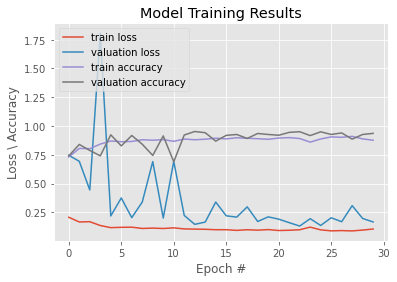

In [52]:
plot_history(history_logs, "Custom")

In [53]:
def plot_roc_curve(model_name, true_y, pred_y):
    """
    Plot the ROC curve along with the curves AUC for a given model. Note make sure true_y and pred_y are from the same model as model_name
    :param model_name: Name of model used for saving plot
    :param true_y: true labels for dataset
    :param pred_y: predicted labels for dataset
    """
    fig, ax = plt.subplots(1,1, figsize=(7,7))
    fpr, tpr, thresholds = sklearn.metrics.roc_curve(true_y, pred_y)
    ax.plot(fpr, tpr, label=f'{model_name} AUC: {sklearn.metrics.auc(fpr,tpr)}')
    ax.legend()
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    plt.savefig(f'Images/{model_name}_roc.png')
    return

def plot_precision_recall_curve(model_name, true_y, pred_y):
    """
    Plot the precision recall curve for a given model. Note make sure true_y and pred_y are from the same model as model_name
    :param model_name: Name of model used for saving plot
    :param true_y: true labels for dataset
    :param pred_y: predicted labels for dataset
    """
    fig, ax = plt.subplots(1,1, figsize=(7,7))
    precision, recall, thresholds = precision_recall_curve(true_y, pred_y)
    ax.plot(recall, precision, label=f'{model_name} AP Score: {sklearn.metrics.average_precision_score(true_y,pred_y)}')
    plt.legend()
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    plt.savefig(f'Images/{model_name}_precision_recall.png')
    return

def calculate_f1_scores(precision, recall):
    return [(2*p*r)/(p+r) for p,r in zip(precision,recall)]

def plot_f1_score(model_name, true_y, pred_y):
    """
    Plot F1 Scores for a given model. Note make sure true_y and pred_y are from the same model as model_name
    F1 = 2*(precision*recall) / (precision + recall)
    :param model_name: Name of model used for saving plot
    :param true_y: true labels for dataset
    :param pred_y: predicted labels for the dataset
    """
    fig, ax = plt.subplots(1,1,figsize=(7,7))
    precision, recall, thresholds = precision_recall_curve(true_y,pred_y)
    ax.plot(thresholds, precision[:-1], label=f'{model_name} Precision')
    ax.plot(thresholds, recall[:-1], label=f'{model_name} Recall')
    f1_scores = calculate_f1_scores(precision, recall)[:-1]
    ax.plot(thresholds, f1_scores, label=f'{model_name} F1 Score')
    plt.legend()
    ax.set_xlabel("Threshold Values")
    plt.savefig(f'Images/{model_name}_f1_score.png')
    return max(f1_scores)

In [54]:
predicted_vals = model.predict(test_generator, steps = len(test_generator))

In [55]:
true_y = test_set['Pneumonia'].values

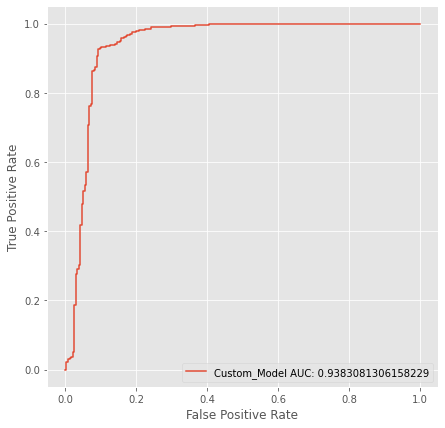

In [58]:
plot_roc_curve("Custom_Model", true_y, predicted_vals)

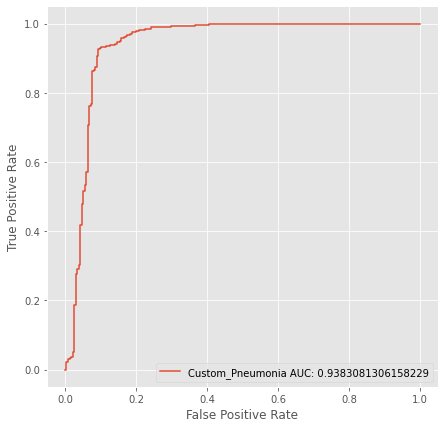

In [60]:
plot_roc_curve("Custom_Pneumonia", true_y, predicted_vals)

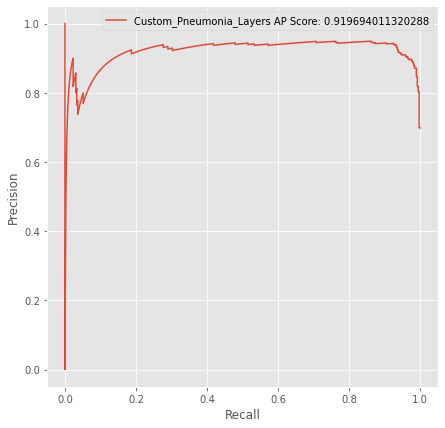

In [61]:
plot_precision_recall_curve('Custom_Pneumonia_Layers', true_y, predicted_vals)

0.9357326478149101

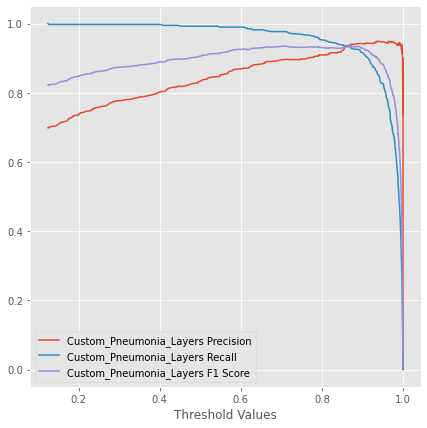

In [62]:
plot_f1_score('Custom_Pneumonia_Layers', true_y, predicted_vals)

In [68]:
[layer.name for layer in model.layers]

['conv2d',
 'conv2d_1',
 'max_pooling2d',
 'sequential',
 'sequential_1',
 'sequential_2',
 'dropout',
 'sequential_3',
 'dropout_1',
 'flatten',
 'sequential_4',
 'sequential_5',
 'sequential_6',
 'dense_3']

In [87]:
def get_mean_std_per_batch(df, H=320, W=320):
    sample_data = []
    for idx, img in enumerate(df.sample(100)["Path"].values):
        sample_data.append(
            np.array(image.load_img(img, target_size=(H, W))))
    mean = np.mean(sample_data[0])
    std = np.std(sample_data[0])
    return mean, std


def load_image(img, df, preprocess=True, H=320, W=320):
    """Load and preprocess image."""
    mean, std = get_mean_std_per_batch(df, H=H, W=W)
    x = image.load_img(img, target_size=(H, W))
    if preprocess:
        x -= mean
        x /= std
        x = np.expand_dims(x, axis=0)
    return x


def grad_cam(input_model, image, cls, H=320, W=320):
    """GradCAM method for visualizing input saliency."""
    y_c = input_model.output[0, cls]
    conv_output = model.layers[-7].layers[-2].output
    grads = K.gradients(y_c, conv_output)[0]
    gradient_function = K.function([input_model.input], [conv_output, grads])

    output, grads_val = gradient_function([image])
    output, grads_val = output[0, :], grads_val[0, :, :, :]
    weights = np.mean(grads_val, axis=(0, 1))
    cam = np.dot(output, weights)

    # Process CAM
    cam = cv2.resize(cam, (W, H), cv2.INTER_LINEAR)
    cam = np.maximum(cam, 0)
    cam = cam / cam.max()
    return cam


def compute_gradcam(model, img, df, labels, selected_labels):
    preprocessed_input = load_image(img, df)
    predictions = model.predict(preprocessed_input)
    print("Loading Original Image...")
    plt.figure(figsize=(15, 10))
    plt.subplot(151)
    plt.title("Original")
    plt.axis('off')
    plt.imshow(load_image(img, df, preprocess=False), cmap='gray')

    j = 1
    for i in range(len(labels)):
        if labels[i] in selected_labels:
            print(f"Generating Gradcam for Class {labels[i]}")
            gradcam = grad_cam(model, preprocessed_input, i)
            plt.subplot(151 + j)
            plt.title(f"{labels[i]}: Prob={predictions[0][i]:.3f}")
            plt.axis('off')
            plt.imshow(load_image(img, df, preprocess=False), cmap='gray')
            plt.imshow(gradcam, cmap='jet', alpha=min(0.5, predictions[0][i]))
            j += 1

In [88]:
labels, labels_to_show = ['Pneumonia'], ['Pneumonia'] 

Original - PNEUMONIA
Loading Original Image...
Generating Gradcam for Class Pneumonia


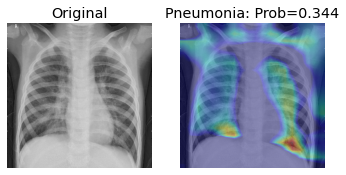

In [89]:
print("Original - PNEUMONIA")
compute_gradcam(model, 'G:\\Downloads\\archive\\chest_xray\\test\\PNEUMONIA\\person20_virus_51.jpeg', train_set, labels, labels_to_show)

Original - NORMAL
Loading Original Image...
Generating Gradcam for Class Pneumonia


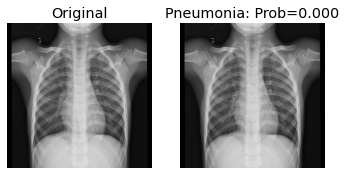

In [90]:
print("Original - NORMAL")
compute_gradcam(model, 'G:\\Downloads\\archive\\chest_xray\\test\\NORMAL\\NORMAL2-IM-0051-0001.jpeg', train_set, labels, labels_to_show)

Original - PNEUMONIA
Loading Original Image...
Generating Gradcam for Class Pneumonia


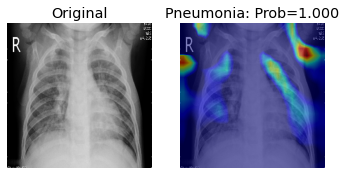

In [91]:
print("Original - PNEUMONIA")
compute_gradcam(model, 'G:\\Downloads\\archive\\chest_xray\\test\\PNEUMONIA\\person1679_virus_2896.jpeg', train_set, labels, labels_to_show)

Original - NORMAL
Loading Original Image...
Generating Gradcam for Class Pneumonia


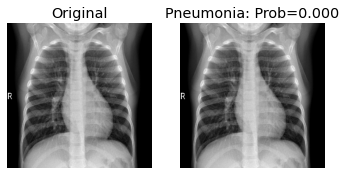

In [93]:
print("Original - NORMAL")
compute_gradcam(model, 'G:\\Downloads\\archive\\chest_xray\\test\\NORMAL\\NORMAL2-IM-0374-0001.jpeg', train_set, labels, labels_to_show)

Original - PNEUMONIA
Loading Original Image...
Generating Gradcam for Class Pneumonia


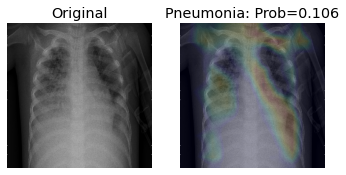

In [96]:
print("Original - PNEUMONIA")
compute_gradcam(model, 'G:\\Downloads\\archive\\chest_xray\\test\\PNEUMONIA\\person1661_virus_2872.jpeg', train_set, labels, labels_to_show)

Original - PNEUMONIA
Loading Original Image...
Generating Gradcam for Class Pneumonia


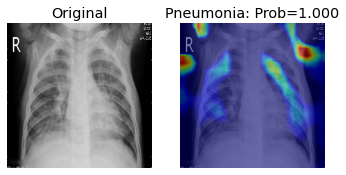

In [98]:
print("Original - PNEUMONIA")
compute_gradcam(model, 'G:\\Downloads\\archive\\chest_xray\\test\\PNEUMONIA\\person1679_virus_2896.jpeg', train_set, labels, labels_to_show)